In [96]:
import numpy as np
import matplotlib.pyplot as plt
kmeans = __import__('1-kmeans').kmeans

In [17]:
"""Task 4: Initialize GMM"""


def initialize(X, k):
    """Initializes variables for a Gaussian Mixture Model
    Args:
        X: np.ndarray of shape (n, d) containing the data set
        k: positive integer containing the number of clusters
    Returns:
        pi: np.ndarray of shape (k,) containing the priors for each cluster,
            initialized evenly
        m: np.ndarray of shape (k, d) containing the centroid means for each
            cluster, initialized with K-means
        S: np.ndarray of shape (k, d, d) containing the covariance matrices
            for each cluster, initialized as identity matrices"""

    if type(k) is not int or k < 1:
        return None, None, None

    try:
        m, _ = kmeans(X, k)
        pi = np.ones((k,)) / k

        _, d = X.shape

        S = np.zeros((k, d, d))
        S[:] = np.eye(d)

        return pi, m, S

    except Exception:
        return None, None, None

In [23]:
"""Task 5: PDF"""


def pdf(X, m, S):
    """Calculates the probability density function of a Gaussian distribution
    Args:
        X: np.ndarray of shape (n, d) containing the data points whose PDF
            should be evaluated
        m: np.ndarray of shape (d,) containing the mean of the distribution
        S: np.ndarray of shape (d, d) containing the covariance of the
            distribution
    Returns:
        P: np.ndarray of shape (n,) containing the PDF values for each data
            point"""

    if type(X) is not np.ndarray or len(X.shape) != 2:
        return None

    if type(m) is not np.ndarray or len(m.shape) != 1:
        return None

    if type(S) is not np.ndarray or len(S.shape) != 2:
        return None

    n, d = X.shape

    if m.shape[0] != d:
        return None

    if S.shape[0] != d or S.shape[1] != d:
        return None

    inv_S = np.linalg.inv(S)
    constant = 1 / np.sqrt((2 * np.pi) ** d * np.linalg.det(S))

    # Broadcasting to subtract mean from each row of X  
    diff = X - m.reshape(1, d)
    exponent = -0.5 * np.sum(np.dot(diff, inv_S) * diff, axis=1)
    P = constant * np.exp(exponent)

    P[P < 1e-300] = 1e-300

    return P

In [49]:
"""Task 6: Expectation"""


def expectation(X, pi, m, S):
    """Calculates the expectation step in the EM algorithm for a GMM
    Args:
        X: np.ndarray of shape (n, d) containing the data set
        pi: np.ndarray of shape (k,) containing the priors for each cluster
        m: np.ndarray of shape (k, d) containing the centroid means for each
            cluster
        S: np.ndarray of shape (k, d, d) containing the covariance matrices
            for each cluster
    Returns:
        g: np.ndarray of shape (k, n) containing the posterior probabilities
            for each data point in each cluster
        l: total log likelihood"""

    if type(X) is not np.ndarray or len(X.shape) != 2:
        return None, None

    if type(pi) is not np.ndarray or len(pi.shape) != 1:
        return None, None

    if type(m) is not np.ndarray or len(m.shape) != 2:
        return None, None

    if type(S) is not np.ndarray or len(S.shape) != 3:
        return None, None

    n, d = X.shape
    k = pi.shape[0]

    if m.shape[0] != k or m.shape[1] != d:
        return None, None

    if S.shape[0] != k or S.shape[1] != d or S.shape[2] != d:
        return None, None

    if not np.isclose(np.sum(pi), 1):
        return None, None

    g = np.zeros((k, n))

    for i in range(k):
        P = pdf(X, m[i], S[i])
        g[i] = pi[i] * P


    l = np.sum(np.log(np.sum(g, axis=0)))
    g /= np.sum(g, axis=0)

    return g, l

In [92]:
"""Task 7: Maximization"""


def maximization(X, g):
    """Calculates the maximization step in the EM algorithm for a GMM
    Args:
        X: np.ndarray of shape (n, d) containing the data set
        g: np.ndarray of shape (k, n) containing the posterior probabilities
            for each data point in each cluster
    Returns:
        pi: np.ndarray of shape (k,) containing the updated priors for each
            cluster
        m: np.ndarray of shape (k, d) containing the updated centroid means
            for each cluster
        S: np.ndarray of shape (k, d, d) containing the updated covariance
            matrices for each cluster"""
    
    if type(X) is not np.ndarray or len(X.shape) != 2:
        return None, None, None

    if type(g) is not np.ndarray or len(g.shape) != 2:
        return None, None, None
    if False in np.isclose(g.sum(axis=0), np.ones((g.shape[1]))):
        return None, None, None

    n, d = X.shape
    k = g.shape[0]

    if g.shape[1] != n:
        return None, None, None

    pi = np.sum(g, axis=1) / n
    m = np.zeros((k, d))
    S = np.zeros((k, d, d))
    # print("g\n", g)

    for i in range(k):
        m[i] = np.sum(g[i].reshape(-1, 1) * X, axis=0) / np.sum(g[i])
        # print("g[i].reshape(-1, 1)\n", g[i].reshape(-1, 1))
        # print("X\n", X)
        # print("m[i]\n", m[i])
        diff = X - m[i]
        # print("diff = X - m[i]\n", diff)
        S[i] = np.dot(g[i].reshape(1, -1) * diff.T, diff) / np.sum(g[i])
        # print("S[i]\n", S[i])

    return pi, m, S

In [94]:
np.random.seed(11)
a = np.random.multivariate_normal([30, 40], [[75, 5], [5, 75]], size=10000)
b = np.random.multivariate_normal([5, 25], [[16, 10], [10, 16]], size=750)
c = np.random.multivariate_normal([60, 30], [[16, 0], [0, 16]], size=750)
d = np.random.multivariate_normal([20, 70], [[35, 10], [10, 35]], size=1000)
X = np.concatenate((a, b, c, d), axis=0)
np.random.shuffle(X)
pi, m, S = initialize(X, 4)
g, _ = expectation(X, pi, m, S)
pi, m, S = maximization(X, g)
print(pi)
print(m)
print(S)

[0.10104901 0.24748822 0.1193333  0.53212947]
[[54.7440558  31.80888393]
 [16.84099873 31.20560148]
 [21.42588061 65.51441875]
 [32.33208369 41.80830251]]
[[[64.05063663 -2.13941814]
  [-2.13941814 41.90354928]]

 [[72.72404579  9.96322554]
  [ 9.96322554 53.05035303]]

 [[46.20933259  1.08979413]
  [ 1.08979413 66.9841323 ]]

 [[35.04054823 -0.94790014]
  [-0.94790014 45.14948772]]]


In [169]:
"""Task 8: EM"""


def expectation_maximization(X, k, iterations=1000, tol=1e-5, verbose=False):
    """Performs the expectation maximization for a GMM
    Args:
        X: np.ndarray of shape (n, d) containing the data set
        k: positive integer containing the number of clusters
        iterations: positive integer containing the maximum number of
            iterations for the algorithm
        tol: non-negative float containing tolerance of the log likelihood,
            used to determine early stopping i.e. if the difference is less
            than or equal to tol you should stop the algorithm
        verbose: boolean that determines if you should print information about
            the algorithm"""

    if type(X) is not np.ndarray or len(X.shape) != 2:
        return None, None, None, None, None

    if type(k) is not int or k <= 0:
        return None, None, None, None, None

    if type(iterations) is not int or iterations <= 0:
        return None, None, None, None, None

    if type(tol) is not float or tol < 0:
        return None, None, None, None, None

    if type(verbose) is not bool:
        return None, None, None, None, None

    pi, m, S = initialize(X, k)

    ll = [0, 0]
    for i in range(iterations + 1):
        g, ll[1] = expectation(X, pi, m, S)
        if verbose and i % 10 == 0:
            print("Log Likelihood after {} iterations: {}"
                  .format(i, ll[1].round(5)))
        if abs(ll[0] - ll[1]) <= tol:
            if verbose:
                print("Log Likelihood after {} iterations: {}"
                      .format(i, ll[1].round(5)))
            break
        if i < iterations:
            pi, m, S = maximization(X, g)

        ll[0] = ll[1]

    return pi, m, S, g, ll[1]

In [177]:
"""Task 9: BIC"""


def BIC(X, kmin=1, kmax=None, iterations=1000, tol=1e-5, verbose=False):
    """Finds the best number of clusters for a GMM using the Bayesian
        Information Criterion
    Args:
        X: np.ndarray of shape (n, d) containing the data set
        kmin: positive integer containing the minimum number of clusters to
            check for (inclusive)
        kmax: positive integer containing the maximum number of clusters to
            check for (inclusive)
        iterations: positive integer containing the maximum number of
            iterations for the EM algorithm
        tol: non-negative float containing the tolerance for the EM algorithm
        verbose: boolean that determines if the EM algorithm should print
            information to the standard output
    Returns: best_k, best_result, ll, b, or None, None, None, None on failure"""

    if type(X) is not np.ndarray or len(X.shape) != 2:
        return None, None, None, None

    if type(kmin) is not int or kmin <= 0:
        return None, None, None, None

    if type(kmax) is not int or kmax <= 0:
        return None, None, None, None

    if kmax is None:
        kmax = X.shape[0]

    if kmin >= kmax:
        return None, None, None, None

    if type(iterations) is not int or iterations <= 0:
        return None, None, None, None

    if type(tol) is not float or tol < 0:
        return None, None, None, None

    if type(verbose) is not bool:
        return None, None, None, None


    n, d = X.shape
    b = []
    loglikelihoods = []
    results = []
    ks = []
    for k in range(kmin, kmax + 1):
        pi, m, S, _, ll = expectation_maximization(X, k, iterations, tol,
                                                   verbose)
        results.append((pi, m, S))
        ks.append(k)
        loglikelihoods.append(ll)
        p = (k * d + k * d + 1)
        # p = k * d * (d + 1) / 2 + d * k + k - 1
        b.append(p * np.log(n) - 2 * ll)

    b = np.array(b) 
    best_k = np.argmin(b)

    return ks[best_k], results[best_k], loglikelihoods, b

4
(array([0.79885962, 0.08044842, 0.06088258, 0.05980938]), array([[29.89606417, 40.12518027],
       [20.0343883 , 69.84718588],
       [60.18888407, 30.19707372],
       [ 5.05788987, 24.92583792]]), array([[[74.52101284,  5.20770764],
        [ 5.20770764, 73.8729309 ]],

       [[35.58334497, 11.08416742],
        [11.08416742, 33.09483747]],

       [[16.85183256,  0.25475122],
        [ 0.25475122, 16.4943092 ]],

       [[15.19520213,  9.62633552],
        [ 9.62633552, 15.47268905]]]))
[-98801.40298365959, -96729.95558846017, -95798.40406023037, -94439.93888881887, -94435.87750008173, -94428.6221717606, -94426.71159745345, -94425.58608709526, -94421.41864281411, -94416.43390835196]
[197649.97338694 193544.81253223 191719.44341146 189040.24700433
 189069.85816255 189093.0814416  189126.99422868 189162.47714366
 189191.87619079 189219.64065756]


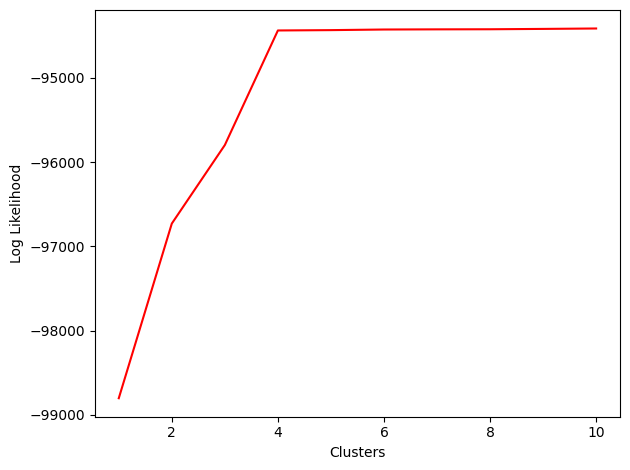

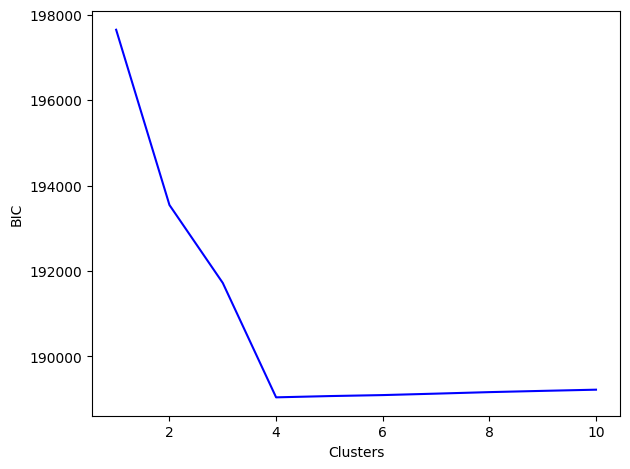

In [178]:
np.random.seed(11)
a = np.random.multivariate_normal([30, 40], [[75, 5], [5, 75]], size=10000)
b = np.random.multivariate_normal([5, 25], [[16, 10], [10, 16]], size=750)
c = np.random.multivariate_normal([60, 30], [[16, 0], [0, 16]], size=750)
d = np.random.multivariate_normal([20, 70], [[35, 10], [10, 35]], size=1000)
X = np.concatenate((a, b, c, d), axis=0)
np.random.shuffle(X)
best_k, best_result, l, b = BIC(X, kmin=1, kmax=10)
print(best_k)
print(best_result)
print(l)
print(b)
x = np.arange(1, 11)
plt.plot(x, l, 'r')
plt.xlabel('Clusters')
plt.ylabel('Log Likelihood')
plt.tight_layout()
plt.show()
plt.plot(x, b, 'b')
plt.xlabel('Clusters')
plt.ylabel('BIC')
plt.tight_layout()
plt.show()